# Homework 04 - TensorFlow

In this homework you will practice what you learned about TensorFlow. You will implement the same network as in the last homework. But instead of using NumPy you will use TensorFlow.

In [0]:
import numpy as np 
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


### Build the dataset.

In [0]:
x = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=np.float32)
#XOR Gate
t = np.array([0,1,1,0], dtype=np.float32)
#AND Gate
#t = np.array([0,0,0,1], dtype=np.float32)
train_dataset = tf.data.Dataset.from_tensor_slices((x,t))
# I added
#test_dataset = tf.data.Dataset.from_tensor_slices((x,t))
#Batching
train_dataset = train_dataset.batch(len(x[:,0]))

In [0]:
len(x[:,0])
x[:,0]

array([0., 0., 1., 1.], dtype=float32)

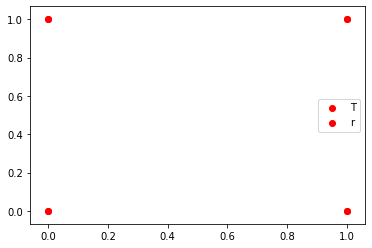

In [0]:
plt.scatter(x = x[:,0],y = x[:,1], c='red')
plt.scatter(x = x[:,0],y = x[:,1], c='red')
plt.legend(("Training Data"))

### The model.

We will build the following model

<img alt="model" src="https://raw.githubusercontent.com/lukeeffenberger/IANNWTF-2019/master/homework-figures/mlp_xor.png" width="500">

The activation function for **all** neurons is the logistic function

$$ \sigma(x) = \frac{1}{1+e^{-x}}. $$

You can reuse many parts from the notebook from the TensorFlow lecture.

When building the model make sure to do the following:
* initialize the weights with a random normal distribution with mean 0.0 and standard deviation 0.5
* initialize the biases with a random normal distribution with mean 0.0 and standard deviation 0.05 

Check 'tf.random_normal_initializer()'.


### Implement the model.

In [0]:
from tensorflow.keras.layers import Layer

### YOUR CODE HERE ###
# Implement the class for a linear layer.

class Linear(Layer):
    """y = w.x + b"""
    
# Inheriting Magick
    def __init__(self, units): # units = number of output neurons 
        super(Linear, self).__init__()

        self.units = units
#Actually initializing the matrices        
    def build(self, input_shape):
        self.w = self.add_weight(
                        shape=(input_shape[-1], self.units),
                        initializer=tf.random_normal_initializer(mean = 0, stddev = .5),
                        trainable=True
        )
        self.b = self.add_weight(
                        shape=(self.units,),
                        initializer=tf.random_normal_initializer(mean = 0, stddev = .05),
                        trainable=True
        )
     
# Call is basically a forward step
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [0]:
# Formally we define another layer. So we have to inherit again.
class MLP(Layer):
    
    def __init__(self):
        # And also call the super init again.
        super(MLP, self).__init__()
        # Here we only instantiate the layers that our network has.
        self.hidden_layer = Linear(4)
        self.output_layer = Linear(1)
        
# Definition of forward step
    def call(self, x):
      #indicate the layer to be used
        x = self.hidden_layer(x)
      # define activation function
        x = tf.math.sigmoid(x) 
        #print(self.hidden_layer.w, 'weights hidden layer')
        #x = tf.nn.relu(x) 
        # compute result
        x = self.output_layer(x)
        #activation function for output layer        
        x = tf.math.sigmoid(x)
        #print(x, 'result from forward step')
        return x

### Train the model.

Now that the model is built we train the network. Again you can reuse parts from the lecture. Note that we do not use any test data here, because there are only four data points.

Make sure you do the following:
* Use mean squared error as loss function.
* Use the SGD optimizer with learning rate 1.
* Train for 500 epochs.
* For each epoch calculate the loss and accuracy and store it in a list. Note that there are no test data.

If your model is not able to achieve 100% accuracy try and run it again. Sometimes you just have bad luck with initialization.

In [0]:
#Clear all prior values
tf.keras.backend.clear_session()
# Instantiate Class 
mlp = MLP()
# Define Loss function
mse = tf.keras.losses.MeanSquaredError()
# Define optimizer and learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=1) #1e-2 would be 0.01
# Store all steps for visualization
train_losses = []
accuracies = []
epochs = []
#Define Nr of training steps
for epoch in range(1000): 
    epochs.append(epoch)
    # Training loop.
    for (x,t) in train_dataset:
        # reshape input to proper dim: 2 bc we have 2 inputs, x1/x2 ; -1 bc then it automatically reshapes the rest accordingly
        #x = tf.reshape(x, shape=(-1,2))

        ## Gradient tape. Veeeery important.
        with tf.GradientTape() as tape:
            output = mlp(x)
            loss = mse(t, output)
            # Compute Accuracy: count of (t - output == 0) /nr of datapoints
            acc = tf.keras.metrics.Accuracy()
            # Rounding to 0 or 1
            round_out = np.around(output.numpy(), decimals=0)
            acc.update_state(t.numpy(), round_out)
            #save in accuracies
            accuracies.append(acc.result().numpy())
            train_losses.append(loss)
            gradients = tape.gradient(loss, mlp.trainable_variables)
        
        # After recording the gradients we can apply them to the 
        # variables.
        optimizer.apply_gradients(zip(gradients, mlp.trainable_variables))



### Visualize the training progress.

In [0]:
import matplotlib.pyplot as plt

Final Loss:  0.011433212
Final Accuracy:  1.0


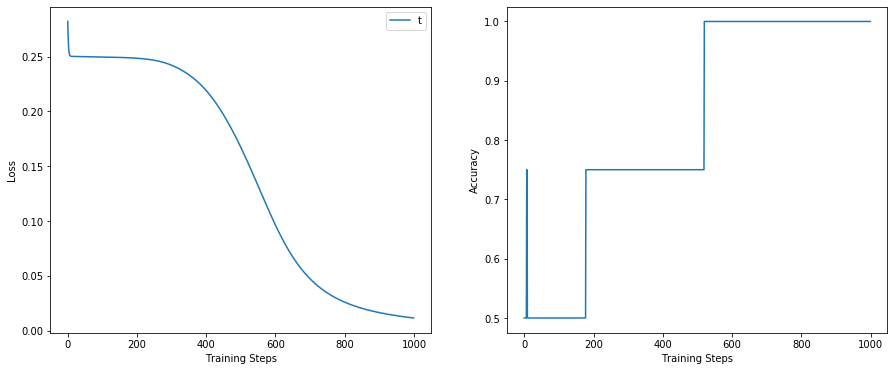

In [0]:
print('Final Loss: ',np.array(train_losses[-1]))
print('Final Accuracy: ',np.array(accuracies[-1]))
fig = plt.figure(figsize=(15,6))
a=fig.add_subplot(1,2,1)
plt.plot(epochs, np.array(train_losses))
plt.legend("train")
plt.xlabel("Training Steps")
plt.ylabel("Loss")

a=fig.add_subplot(1,2,2)
plt.plot(epochs, np.array(accuracies))
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")

plt.show()